## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [24]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from pprint import pprint
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [8]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json')

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [9]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
#print the column names

col_list=list(df.columns)
col_list

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

In [11]:
#Assign new column names
#Removing "_" from column names
df.columns=[re.sub('^_','',col) for col in df.columns]

#Removing "source." from column names
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]

list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [12]:
#Assign nan in place of blanks in the complaint_what_happened column
df['complaint_what_happened'].replace('', np.nan, inplace=True)
# Null values count after replacing blanks with nan
df['complaint_what_happened'].isnull().sum()



57241

In [13]:
#Remove all rows where complaint_what_happened column is nan
df.dropna(subset=['complaint_what_happened'],inplace=True)

In [16]:
df.head()


,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
#Make the text lowercase
def clean_texts(text):
    #Make the text lowercase
    text=text.lower()

    #Remove text in square brackets
    text=re.sub(r'\[.*?\]','',text)

    #Remove punctuation
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text)

    #Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text


In [20]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words
def lemmatization(texts):
    lemma_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.lemma_ for token in doc if token.text not in set(stopwords)]
        lemma_sentences.append(' '.join(sent))
    return lemma_sentences

In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [39]:
df_clean = pd.DataFrame()
df_clean['complaint_what_happened'] = df['complaint_what_happened']

In [40]:
df_clean.columns

Index(['complaint_what_happened'], dtype='object')

In [41]:
# Add a column for lemmatized complaints to the dataframe
df_clean["lemmatized_complaint"] =  lemmatization(df_clean['complaint_what_happened'])

# View the dataframe
df_clean.head()

21072it [15:34, 22.54it/s]


,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,upgrade xxxx xxxx card xx / xx/ tell agent upg...
10,"chase card was reported on xx/xx/. however, fr...","chase card report xx / xx/. , fraudulent appli..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","xx / xx/ , try book xxxx xxxx ticket , com..."
14,my grand son give me check for {$.} i deposit ...,grand son check { $ . } deposit chase account ...


In [42]:
# adding category and sub_category columns for better topic identification
df_clean['category'] = df['product']
df_clean['sub_category'] = df['sub_product']

In [44]:
def extract_pos_tags(texts):
    pos_sentences = []
    for doc in tqdm(nlp.pipe(texts)):
        sent = [token.text for token in doc if token.tag_ == 'NN']
        pos_sentences.append(' '.join(sent))
    return pos_sentences

df_clean["complaint_POS_removed"] = extract_pos_tags(df_clean['lemmatized_complaint'])

21072it [07:33, 46.43it/s]


In [45]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,lemmatized_complaint,category,sub_category,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,Debt collection,Credit card debt,morning help bank cardmember service chase deb...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,upgrade xxxx xxxx card xx / xx/ tell agent upg...,Credit card or prepaid card,General-purpose credit card or charge card,card agent anniversary date change agent infor...
10,"chase card was reported on xx/xx/. however, fr...","chase card report xx / xx/. , fraudulent appli...","Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","xx / xx/ , try book xxxx xxxx ticket , com...","Credit reporting, credit repair services, or o...",Credit reporting,book ticket offer ticket reward card informati...
14,my grand son give me check for {$.} i deposit ...,grand son check { $ . } deposit chase account ...,Checking or savings account,Checking account,son deposit chase account fund bank account pa...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,"chase card customer decade , offer multiple so...",Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","wednesday , xx / xx / xxxx call chas , xxxx xx...",Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,Checking or savings account,Checking account,xxxx risk consumer app chase year trust mobile...
78311,i have had flawless credit for yrs. i've had ...,"flawless credit yrs . chase credit card , "" ...",Credit card or prepaid card,General-purpose credit card or charge card,credit yrs chase credit card chase freedom pro...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length'] = df_clean['complaint_what_happened'].str.len()
df_clean['lemmatized_complaint'] = df_clean['lemmatized_complaint'].str.len()
df_clean['complaint_POS_removed_length'] = df_clean['complaint_POS_removed'].str.len()

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_clean['complaint_length'], name='Complaint'))
fig.add_trace(go.Histogram(x=df_clean['lemmatized_complaint'], name='Complaint Lemmatized'))
fig.add_trace(go.Histogram(x=df_clean['complaint_POS_removed_length'], name='Complaint POS Removed'))
fig.update_layout(barmode='overlay', title='Complaint Character Length', xaxis_title='Character Length', yaxis_title='Count')
fig.update_traces(opacity=0.75)
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

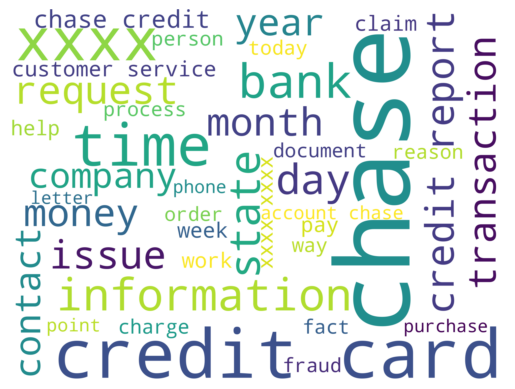

In [49]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud=WordCloud(stopwords=stopwords, background_color='white', width=2000, height=1500,max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
plt.axis("off")
plt.show()

In [50]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [56]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_unigram(text, n=30):

    vector = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [57]:
#Print the top 10 words in the unigram frequency
top_common_words = get_top_unigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_unigram = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
df_unigram.head(10)

,unigram,count
0,chase,48759
1,account,41207
2,credit,33797
3,xxxx,32135
4,card,29954
5,payment,21291
6,time,16132
7,bank,14955
8,charge,14634
9,day,12938


In [54]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_bigram(text, n=30):

    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [55]:
#Print the top 10 words in the bigram frequency
top_common_words = get_top_bigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
df_bigram.head(10)

,bigram,count
0,credit card,12847
1,credit report,3914
2,chase credit,3044
3,customer service,2900
4,xxxx xxxx,2840
5,account chase,2269
6,chase account,1936
7,debit card,1877
8,contact chase,1828
9,account account,1787


In [58]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
def get_top_trigram(text, n=30):

    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

In [59]:
#Print the top 10 words in the trigram frequency
top_common_words = get_top_trigram(df_clean['complaint_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
df_trigram.head(10)

,trigram,count
0,chase credit card,2222
1,credit card account,1070
2,credit card company,981
3,xxxx xxxx xxxx,733
4,credit card chase,705
5,xxxx credit card,677
6,chase customer service,520
7,inquiry credit report,495
8,credit card credit,475
9,credit reporting agency,384


<ipython-input-62-d3c4f40b4f3f>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




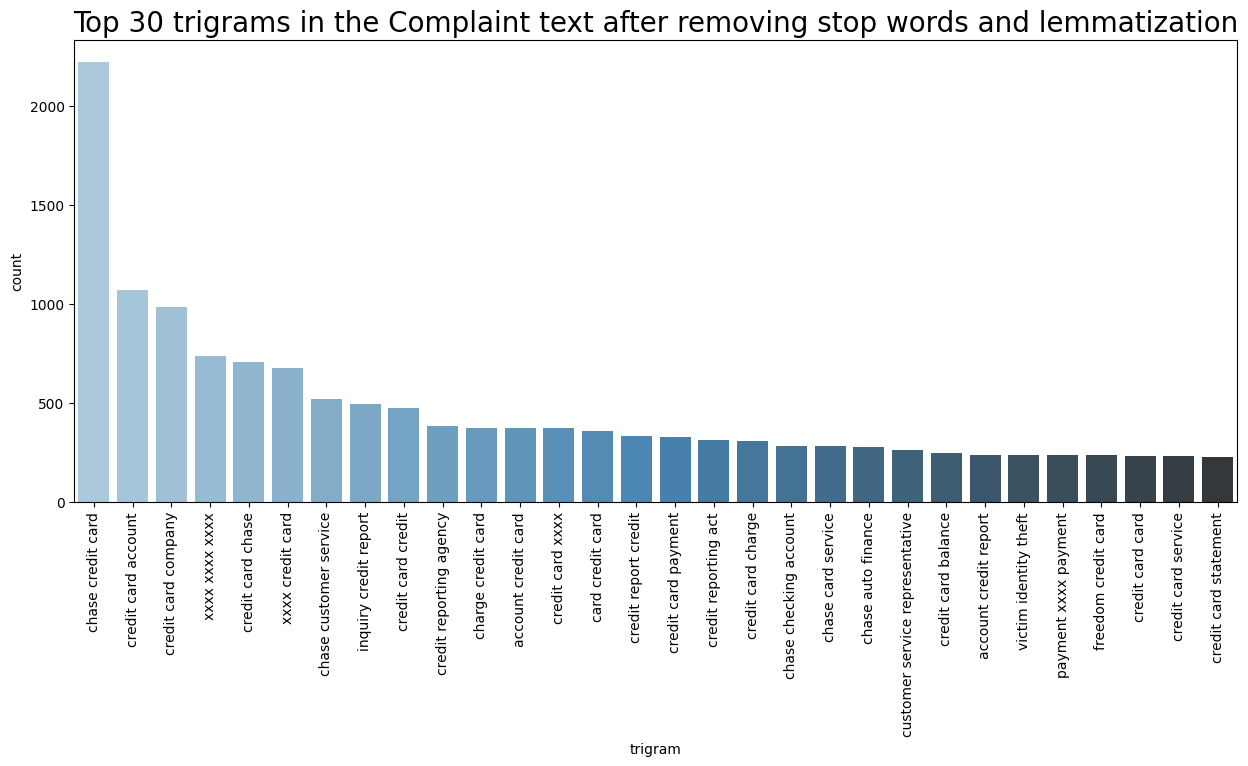

In [62]:
# Plot the top 30 trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Blues_d")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=20)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [63]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [64]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,category,sub_category,complaint_POS_removed,complaint_length,complaint_POS_removed_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,312,Debt collection,Credit card debt,morning help bank cardmember service chase deb...,482,160,morning help bank cardmember service chase deb...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,237,Credit card or prepaid card,General-purpose credit card or charge card,card agent anniversary date change agent infor...,351,112,card agent anniversary date change agent infor...
10,"chase card was reported on xx/xx/. however, fr...",148,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,220,94,chase card report application submit identity ...
11,"on xx/xx/, while trying to book a xxxx xxxx ...",817,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket offer ticket reward card informati...,1470,391,book ticket offer ticket reward card informati...
14,my grand son give me check for {$.} i deposit ...,297,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,466,156,son deposit chase account fund bank account pa...
...,...,...,...,...,...,...,...,...
78303,after being a chase card customer for well ove...,411,Credit card or prepaid card,General-purpose credit card or charge card,chase card customer decade solicitation credit...,668,253,chase card customer decade solicitation credit...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",1236,Credit card or prepaid card,General-purpose credit card or charge card,credit card provider claim purchase protection...,2113,689,credit card provider claim purchase protection...
78310,i am not familiar with xxxx pay and did not un...,1385,Checking or savings account,Checking account,xxxx risk consumer app chase year trust mobile...,2317,699,risk consumer app chase year trust mobile ban...
78311,i have had flawless credit for yrs. i've had ...,1321,Credit card or prepaid card,General-purpose credit card or charge card,credit yrs chase credit card chase freedom pro...,2129,505,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [65]:
#Write your code here to initialise the TfidfVectorizer

tf_idf_vec=TfidfVectorizer(max_df=0.98,min_df=2,stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [66]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf=tf_idf_vec.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [68]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [69]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [72]:
nmf_model.fit(tfidf)
len(tf_idf_vec.get_feature_names_out())

6226

In [73]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index} with tf-idf score')
    print([tf_idf_vec.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0 with tf-idf score
['time', 'customer', 'transaction', 'business', 'transfer', 'number', 'day', 'branch', 'chase', 'fund', 'bank', 'deposit', 'money', 'check', 'account']


THE TOP 15 WORDS FOR TOPIC #1 with tf-idf score
['service', 'reason', 'time', 'application', 'month', 'point', 'purchase', 'limit', 'year', 'score', 'account', 'balance', 'chase', 'credit', 'card']


THE TOP 15 WORDS FOR TOPIC #2 with tf-idf score
['date', 'statement', 'property', 'rate', 'balance', 'home', 'pay', 'year', 'time', 'modification', 'month', 'chase', 'mortgage', 'loan', 'payment']


THE TOP 15 WORDS FOR TOPIC #3 with tf-idf score
['letter', 'dispute', 'score', 'theft', 'identity', 'account', 'file', 'remove', 'reporting', 'debt', 'company', 'information', 'credit', 'inquiry', 'report']


THE TOP 15 WORDS FOR TOPIC #4 with tf-idf score
['email', 'statement', 'time', 'contact', 'service', 'fraud', 'purchase', 'refund', 'claim', 'merchant', 'chase', 'transaction', 'fee', 'dispu

In [74]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_values = nmf_model.transform(tfidf)
topic_values.argmax(axis=1)

array([0, 1, 3, ..., 4, 1, 2])

In [75]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_values.argmax(axis=1)

In [76]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,category,sub_category,complaint_POS_removed,complaint_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,312,Debt collection,Credit card debt,morning help bank cardmember service chase deb...,482,160,morning help bank cardmember service chase deb...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,237,Credit card or prepaid card,General-purpose credit card or charge card,card agent anniversary date change agent infor...,351,112,card agent anniversary date change agent infor...,1
10,"chase card was reported on xx/xx/. however, fr...",148,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,220,94,chase card report application submit identity ...,3
11,"on xx/xx/, while trying to book a xxxx xxxx ...",817,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket offer ticket reward card informati...,1470,391,book ticket offer ticket reward card informati...,3
14,my grand son give me check for {$.} i deposit ...,297,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,466,156,son deposit chase account fund bank account pa...,0


In [77]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,category,sub_category,complaint_POS_removed,complaint_length,complaint_POS_removed_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,312,Debt collection,Credit card debt,morning help bank cardmember service chase deb...,482,160,morning help bank cardmember service chase deb...,0
24,mishandling of this account by chase auto and ...,35,Vehicle loan or lease,Loan,mishandle account chase auto xxxx,51,33,mishandle account chase auto,0
17,with out notice j.p. morgan chase restricted m...,1311,Checking or savings account,Checking account,account debit card branch customer service rep...,2265,622,account debit card branch customer service rep...,0
14,my grand son give me check for {$.} i deposit ...,297,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,466,156,son deposit chase account fund bank account pa...,0
27,i opened an account with chase bank on xxxx an...,206,Checking or savings account,Checking account,account term account xxxx deposit bonus day xx...,409,90,account term account deposit bonus day depos...,0
32,my chase amazon card was declined for a cateri...,1106,Credit card or prepaid card,General-purpose credit card or charge card,catering order place brother contact chase noo...,1949,542,catering order place brother contact chase noo...,1
59,i currently have over xxxx chase ultimate rewa...,1125,Credit card or prepaid card,General-purpose credit card or charge card,xxxx reward point month access chase reward ac...,1883,521,reward point month access chase reward accoun...,1
52,my roommate was stealing my chase debit card a...,551,Checking or savings account,Checking account,roommate chase debit card driver license money...,809,236,roommate chase debit card driver license money...,1
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,237,Credit card or prepaid card,General-purpose credit card or charge card,card agent anniversary date change agent infor...,351,112,card agent anniversary date change agent infor...,1
50,i am a senior citizen that has been scammed by...,149,Credit card or prepaid card,General-purpose credit card or charge card,citizen time share company refund credit card ...,343,65,citizen time share company refund credit card ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [78]:
#Create the dictionary of Topic names and Topics

Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}
#Replace Topics with Topic Names
df_clean['Topic_category'] = df_clean['Topic'].map(Topic_names)

<ipython-input-78-09d5eaf3d0de>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
df_clean

,complaint_what_happened,lemmatized_complaint,category,sub_category,complaint_POS_removed,complaint_length,complaint_POS_removed_length,Complaint_clean,Topic,Topic_category
1,good morning my name is xxxx xxxx and i apprec...,312,Debt collection,Credit card debt,morning help bank cardmember service chase deb...,482,160,morning help bank cardmember service chase deb...,0,Bank Account services
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,237,Credit card or prepaid card,General-purpose credit card or charge card,card agent anniversary date change agent infor...,351,112,card agent anniversary date change agent infor...,1,Credit card or prepaid card
10,"chase card was reported on xx/xx/. however, fr...",148,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report application submit identity ...,220,94,chase card report application submit identity ...,3,Theft/Dispute Reporting
11,"on xx/xx/, while trying to book a xxxx xxxx ...",817,"Credit reporting, credit repair services, or o...",Credit reporting,book ticket offer ticket reward card informati...,1470,391,book ticket offer ticket reward card informati...,3,Theft/Dispute Reporting
14,my grand son give me check for {$.} i deposit ...,297,Checking or savings account,Checking account,son deposit chase account fund bank account pa...,466,156,son deposit chase account fund bank account pa...,0,Bank Account services
15,can you please remove inquiry,14,"Credit reporting, credit repair services, or o...",Credit reporting,inquiry,29,7,inquiry,3,Theft/Dispute Reporting
17,with out notice j.p. morgan chase restricted m...,1311,Checking or savings account,Checking account,account debit card branch customer service rep...,2265,622,account debit card branch customer service rep...,0,Bank Account services
20,"during the summer months, i experience a decli...",958,Vehicle loan or lease,Loan,summer month experience income employment mont...,1392,526,summer month experience income employment mont...,2,Others
21,"on xxxx xx/xx/, i made a {$.} payment to an on...",1937,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,payment retailer chase pay xxxx chase website ...,3528,1154,payment retailer chase pay chase website scam...,4,Mortgage/Loan
23,i have a chase credit card which is incorrectl...,87,Credit card or prepaid card,General-purpose credit card or charge card,chase credit card datum credit report company ...,129,51,chase credit card datum credit report company ...,3,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [80]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [81]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,1
10,"chase card was reported on xx/xx/. however, fr...",3
11,"on xx/xx/, while trying to book a xxxx xxxx ...",3
14,my grand son give me check for {$.} i deposit ...,0
15,can you please remove inquiry,3
17,with out notice j.p. morgan chase restricted m...,0
20,"during the summer months, i experience a decli...",2
21,"on xxxx xx/xx/, i made a {$.} payment to an on...",4
23,i have a chase credit card which is incorrectl...,3


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [82]:

#Write your code to get the Vector count
count_vect=CountVectorizer()

X_train_counts=count_vect.fit_transform(training_data['complaint_what_happened'])
#Write your code here to transform the word vector to tf-idf
tfidf_transformer=TfidfTransformer()
X_train_tf=tfidf_transformer.fit_transform(X_train_counts)



You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [83]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# importing libraries required for model building and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split

from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay



In [94]:
# Prepare the training and test data
train_X, test_X, train_y, test_y = train_test_split(X_train_tf, training_data['Topic'], test_size=0.2, random_state=40,stratify=training_data['Topic'])

In [85]:
# function to evaluate the model and display the results
def eval_model(y_test,y_pred,y_pred_proba,type='Training'):
    print(type,'results')
    print('Accuracy: ', accuracy_score(y_test,y_pred).round(2))
    print('Precision: ', precision_score(y_test,y_pred,average='weighted').round(2))
    print('Recall: ', recall_score(y_test,y_pred,average='weighted').round(2))
    print('F1 Score: ', f1_score(y_test,y_pred,average='weighted').round(2))
    print('ROC AUC Score: ', roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr').round(2))
    print('Classification Report: ', classification_report(y_test,y_pred))
    cm = confusion_matrix(y_test,y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=training_data['Topic'].unique())
    disp.plot()

In [90]:
def run_model(model,param_grid):
    cv=StratifiedKFold(n_splits=3,shuffle=True,random_state=40)
    grid=GridSearchCV(model,param_grid=param_grid,cv=cv,scoring='f1_weighted',verbose=1,n_jobs=-1) # Use the provided param_grid
    grid.fit(train_X,train_y)
    return grid.best_estimator_

Logistic Regression

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


1620 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError:

Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Test results
Accuracy:  0.4
Precision:  0.4
Recall:  0.4
F1 Score:  0.4
ROC AUC Score:  0.7
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
    

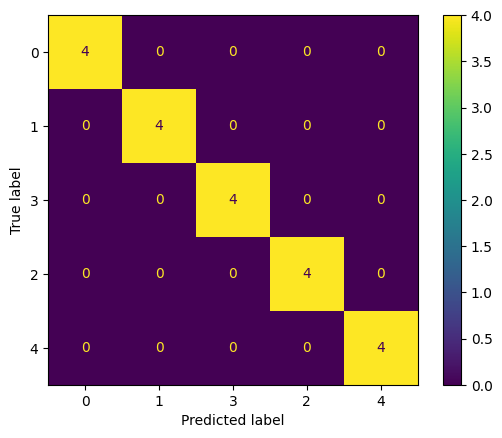

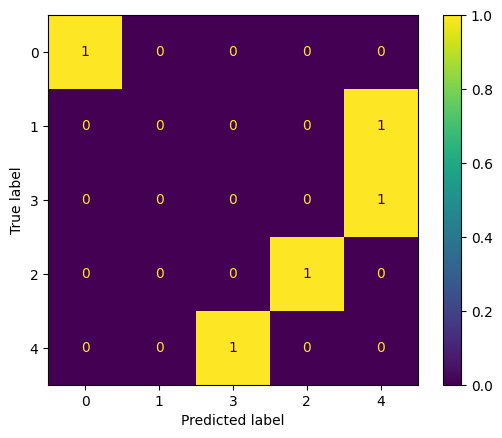

In [95]:
#running and evaluating the Logistic Regression model
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 500, 1000],
    'class_weight': [None, 'balanced']
}
model=run_model(LogisticRegression(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits
Training results
Accuracy:  0.75
Precision:  0.82
Recall:  0.75
F1 Score:  0.74
ROC AUC Score:  0.95
Classification Report:                precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.50      0.75      0.60         4
           2       1.00      0.50      0.67         4
           3       0.80      1.00      0.89         4
           4       1.00      0.50      0.67         4

    accuracy                           0.75        20
   macro avg       0.82      0.75      0.74        20
weighted avg       0.82      0.75      0.74        20

Test results
Accuracy:  0.2
Precision:  0.05
Recall:  0.2
F1 Score:  0.08
ROC AUC Score:  0.38
Classification Report:                precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

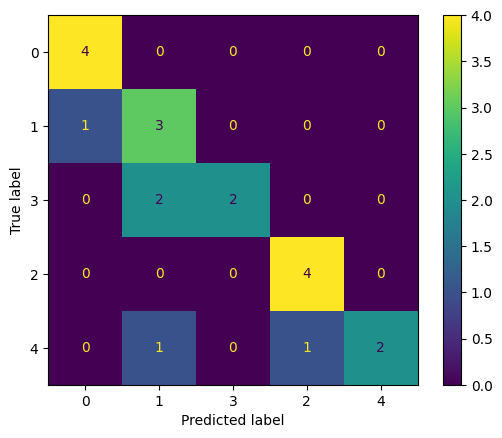

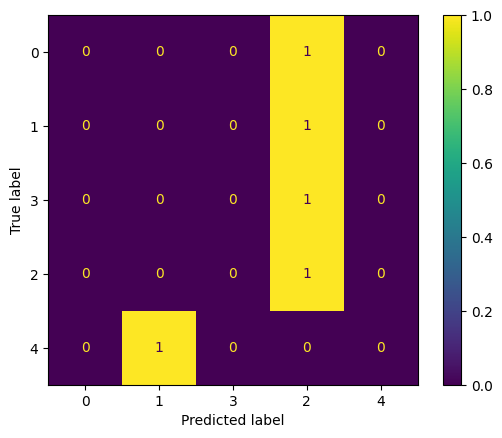

In [96]:
#running and evaluating the Decision Tree model
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'max_features': [None, 'auto', 'sqrt', 'log2']
}
model=run_model(DecisionTreeClassifier(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
Training results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
ROC AUC Score:  1.0
Classification Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Test results
Accuracy:  0.4
Precision:  0.3
Recall:  0.4
F1 Score:  0.33
ROC AUC Score:  0.8
Classification Report:                precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

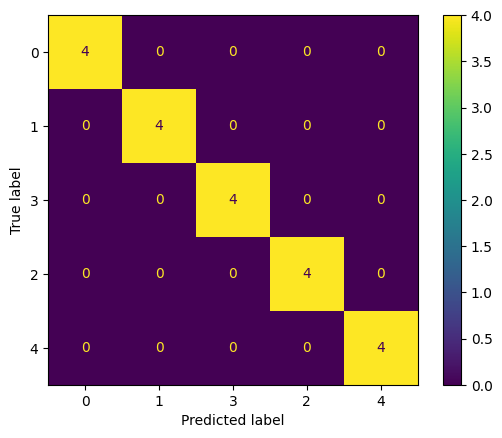

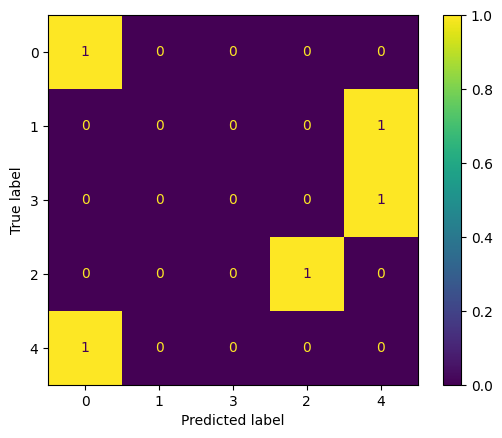

In [98]:
#running and evaluating the XGBoost model
params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0, 0.5, 1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}
model=run_model(XGBClassifier(),params)
eval_model(train_y,model.predict(train_X),model.predict_proba(train_X),type='Training')
eval_model(test_y,model.predict(test_X),model.predict_proba(test_X),type='Test')